In [ ]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import KFold
import numpy as np
import albumentations as A
from tensorflow import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import scipy.ndimage as nd
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

import numpy as np
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, classification_report
import torch
from torch_geometric.nn import GINConv, JumpingKnowledge
from skimage.filters import threshold_otsu, gaussian
from skimage.transform import resize
from skimage.morphology import skeletonize, binary_dilation
import networkx as nx
from torch_geometric.data import Data
from torch_geometric.data import Dataset 
import torch.nn.functional as F
import cv2
import matplotlib.pyplot as plt

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Syntetische data inladen

In [2]:
# Stap 1: Dataset laden
def load_dataset(dataset_dir):
    X, y = [], []
    label_map = {str(i): i for i in range(10)}
    
    for label_str in os.listdir(dataset_dir):
        label_path = os.path.join(dataset_dir, label_str)
        if not os.path.isdir(label_path):
            continue

        for fname in os.listdir(label_path):
            img_path = os.path.join(label_path, fname)
            img = load_img(img_path, color_mode='grayscale', target_size=(64, 64))
            X.append(img_to_array(img) / 255.0)
            y.append(label_map[label_str])
    
    return np.array(X), np.array(y)

X, y = load_dataset("synthetic_digits/train")
X, y = shuffle(X, y, random_state=2003)

In [3]:
print("Converteer originele afbeeldingen naar gereconstrueerde binaire beelden...")

Converteer originele afbeeldingen naar gereconstrueerde binaire beelden...


# Graaf data toevoegen

In [5]:
def resize_with_padding(img, target_size=64, inner_size=60):
    """
    Resize afbeelding proportioneel zodat het in 'inner_size' past
    en vul aan met padding tot 'target_size' x 'target_size'.
    """
    h, w = img.shape
    scale = min(inner_size / h, inner_size / w)
    new_h, new_w = int(h * scale), int(w * scale)
    resized = resize(img, (new_h, new_w), mode='constant', anti_aliasing=True)
    pad_h = target_size - new_h
    pad_w = target_size - new_w
    top = pad_h // 2
    bottom = pad_h - top
    left = pad_w // 2
    right = pad_w - left
    return np.pad(resized, ((top, bottom), (left, right)), mode='constant', constant_values=0)

def preprocess_image(img, target_size=64, inner_size=60):
    """
    Preprocess een grijswaarde-afbeelding tot een skeleton:
    normalisatie, Otsu-binarisatie, crop, resize, smooth, skeletonize.
    """
    img = img / 255.0 if img.max() > 1 else img
    threshold = threshold_otsu(img)
    binary = img > threshold

    rows, cols = np.any(binary, axis=1), np.any(binary, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    margin = 1
    rmin = max(rmin - margin, 0)
    rmax = min(rmax + margin, img.shape[0] - 1)
    cmin = max(cmin - margin, 0)
    cmax = min(cmax + margin, img.shape[1] - 1)
    cropped = img[rmin:rmax+1, cmin:cmax+1]

    resized = resize_with_padding(cropped, target_size, inner_size)
    smoothed = gaussian(resized, sigma=1.0)
    binary = smoothed > threshold_otsu(smoothed)

    skeleton1 = skeletonize(binary)
    dilated = binary_dilation(skeleton1)
    skeleton = skeletonize(dilated)
    return skeleton

def skeleton_to_graph(skeleton):
    """
    Zet een skeleton afbeelding om naar een graf waarbij pixels knopen zijn
    en randen tussen naburige skeletpunten worden gelegd.
    """
    coords = np.argwhere(skeleton)
    G = nx.Graph()
    for y, x in coords:
        G.add_node((x, y))
        for dy in [-1, 0, 1]:
            for dx in [-1, 0, 1]:
                if dx == 0 and dy == 0:
                    continue
                ny, nx_ = y + dy, x + dx
                if 0 <= ny < skeleton.shape[0] and 0 <= nx_ < skeleton.shape[1]:
                    if skeleton[ny, nx_]:
                        G.add_edge((x, y), (nx_, ny))
    return G

def project_graph_to_grid(G, grid_size=8, image_size=64):
    """
    Projecteer een graf op een raster van formaat grid_size x grid_size.
    Elke knoop wordt gemapt naar een cel en randen tussen cellen worden toegevoegd.
    """
    cell_size = image_size // grid_size
    G_projected = nx.Graph()
    point_to_cell = {}
    added_edges = set()

    for x, y in G.nodes:
        cx = int(x / cell_size)
        cy = int(y / cell_size)
        cell = (cx, cy)
        point_to_cell[(x, y)] = cell
        G_projected.add_node(cell)

    for u, v in G.edges:
        cu = point_to_cell.get(u)
        cv = point_to_cell.get(v)
        if cu and cv and cu != cv:
            edge = tuple(sorted((cu, cv)))
            if edge not in added_edges:
                G_projected.add_edge(*edge)
                added_edges.add(edge)

    return G_projected


def graph_to_pyg_data(G, grid_size=8, label=None):
    """
    Zet een graf om naar een PyTorch Geometric 'Data' object
    met one-hot node features, bidirectionele randen en optioneel een label.
    """
    num_nodes = grid_size * grid_size
    node_index_map = { (x, y): y * grid_size + x for x in range(grid_size) for y in range(grid_size) }

    features = []
    for y in range(grid_size):
         for x in range(grid_size):
            idx = y * grid_size + x
            one_hot = torch.zeros(num_nodes)
            one_hot[idx] = 1.0
            features.append(one_hot)

    x = torch.stack(features) 

    edge_index = []
    for (u, v) in G.edges:
        uid = node_index_map.get(u)
        vid = node_index_map.get(v)
        if uid is not None and vid is not None:
            edge_index.append([uid, vid])
            edge_index.append([vid, uid])

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    data = Data(x=x, edge_index=edge_index)

    if label is not None:
        data.y = torch.tensor([label], dtype=torch.long)

    return data


class PyGSkeletonDataset(Dataset):
    """
    Dataset-klasse die afbeeldingen omzet in geskeletoniseerde grafen,
    geprojecteerd op een rooster, klaar voor gebruik in PyTorch Geometric.
    """
    def __init__(self, images, labels=None, grid_size=8):
        """
        Initialiseert de dataset door elke afbeelding om te zetten in een PyG graf.
        
        Args:
            images (list or array): Lijst van grijswaarde-afbeeldingen.
            labels (list or array, optional): Optionele labels per afbeelding.
            grid_size (int): Grootte van het raster (bijv. 8 voor 8x8).
        """
        self.images = images
        self.labels = labels
        self.grid_size = grid_size
        self.graphs = [self._image_to_graph(img, i) for i, img in enumerate(images)]

    def _image_to_graph(self, img, idx):
        """
        Zet één afbeelding om naar een geskeletoniseerde, gerasterde graf.
        
        Args:
            img (np.ndarray): Grijswaarde-afbeelding.
            idx (int): Index van de afbeelding, gebruikt om het juiste label te vinden.
        
        Returns:
            torch_geometric.data.Data: Graph-representatie van de afbeelding.
        """
        skeleton = preprocess_image(img)
        G = skeleton_to_graph(skeleton)
        G_proj = project_graph_to_grid(G, grid_size=self.grid_size)
        label = self.labels[idx] if self.labels is not None else None
        return graph_to_pyg_data(G_proj, grid_size=self.grid_size, label=label)

    def __len__(self):
        """
        Geeft het aantal grafen in de dataset.
        """
        return len(self.graphs)

    def __getitem__(self, idx):
        """
        Haalt één PyG graf op uit de dataset.
        
        Args:
            idx (int): Index van het gewenste datapunt.
        
        Returns:
            torch_geometric.data.Data: De graf op positie idx.
        """
        return self.graphs[idx]
    

def edge_index_to_image(edge_index, image_size=64, grid_size=8, line_thickness=3):
    """
    Zet een edge_index om naar een binair beeld (float32, 0-1) door lijnen te tekenen
    tussen de knopen van een 8x8 grid. Output is shape (64, 64) in float.
    """
    # Leeg canvas
    img = np.zeros((image_size, image_size), dtype=np.uint8)

    # Celgrootte en coördinaten berekenen
    cell_size = image_size // grid_size
    positions = {
        i: (int((i % grid_size + 0.5) * cell_size),
            int((i // grid_size + 0.5) * cell_size))
        for i in range(grid_size * grid_size)
    }

    # Lijnen tekenen
    for u, v in edge_index.t().tolist():
        pt1 = positions[u]
        pt2 = positions[v]
        cv2.line(img, pt1, pt2, color=255, thickness=line_thickness)

    # Schalen naar float32 in [0, 1]
    img = img.astype(np.float32) / 255.0

    return img

In [ ]:
# Zet afbeeldingen om naar PyG skeleton dataset
pyg_dataset = PyGSkeletonDataset(images=X.squeeze(), labels=y, grid_size=8)


In [ ]:
# Parameters
grid_size = 8

reconstructed_binary_images = []

for img in X.squeeze():  # X shape: (N, 64, 64, 1) of (N, 64, 64)
    # 1. Preprocess naar skeleton
    skeleton = preprocess_image(img.squeeze())  # Zorg dat het 2D is

    # 2. Skeleton naar graaf
    G = skeleton_to_graph(skeleton)

    # 3. Projecteer graaf op grid
    G_proj = project_graph_to_grid(G, grid_size=grid_size)

    # 4. Maak edge_index
    num_nodes = grid_size * grid_size
    node_index_map = {(x, y): y * grid_size + x for x in range(grid_size) for y in range(grid_size)}

    edge_index = []
    for u, v in G_proj.edges:
        uid = node_index_map.get(u)
        vid = node_index_map.get(v)
        if uid is not None and vid is not None:
            edge_index.append([uid, vid])
            edge_index.append([vid, uid])
    
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # 5. Zet om naar binair beeld
    binary_img = edge_index_to_image(edge_index, image_size=64, grid_size=grid_size)
    reconstructed_binary_images.append(binary_img)

# Zet om naar array met juiste shape
X_reconstructed = np.expand_dims(np.array(reconstructed_binary_images), axis=-1).astype(np.float32)

# Combineer met originele dataset
X_combined = np.concatenate([X, X_reconstructed], axis=0)
y_combined = np.concatenate([y, y], axis=0)

# Shuffle einddataset (optioneel)
X_combined, y_combined = shuffle(X_combined, y_combined, random_state=42)

print(f"Nieuwe dataset bevat {X_combined.shape[0]} beelden.")


Nieuwe dataset bevat 1780 beelden.


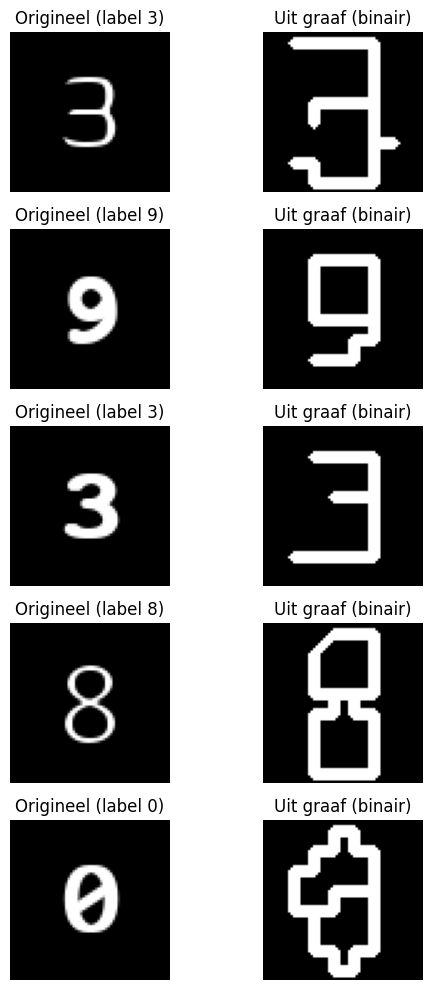

In [ ]:
# Aantal te tonen voorbeelden
n = 5
indices = np.random.choice(len(y), size=n, replace=False)

fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(6, n * 2))

for i, idx in enumerate(indices):
    # Linker kolom: origineel
    axes[i, 0].imshow(X[idx].squeeze(), cmap='gray')
    axes[i, 0].set_title(f"Origineel (label {y[idx]})")
    axes[i, 0].axis('off')

    # Rechter kolom: gereconstrueerd uit graaf
    axes[i, 1].imshow(X_reconstructed[idx].squeeze(), cmap='gray')
    axes[i, 1].set_title("Uit graaf (binair)")
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()


# Augmentatie en ruis

In [14]:
def voeg_rafelruis_toe(img, ruis_std=0.02, drempel=0.6):
    if img.max() > 1.0:
        img = img / 255.0
    if img.ndim == 3:
        img = img.mean(axis=-1)

    binair = (img > drempel).astype(np.float32)
    dx = nd.sobel(binair, axis=0)
    dy = nd.sobel(binair, axis=1)
    rand = np.hypot(dx, dy)

    jitter = np.random.normal(loc=0.0, scale=ruis_std, size=img.shape)
    jitter = gaussian_filter(jitter, sigma=0.3)
    masker = (rand > 0.1) & (np.random.rand(*img.shape) < 0.3)
    img = img + (jitter * masker)

    img = np.clip(img, 0.0, 1.0)
    binair = (img > drempel).astype(np.float32)
    return np.expand_dims(binair, axis=-1)

# Augmentatie voor directe paden (sterk)
strong_albu = A.Compose([
    A.LongestMaxSize(128),
    A.Rotate(limit=10),
    A.Affine(scale=(0.85, 1.15)),
    A.Affine(shear={"x": (-10, 10), "y": (-10, 10)}),
    A.ShiftScaleRotate(shift_limit=0.15, scale_limit=0, rotate_limit=0),
    A.OneOf([
        A.Perspective(scale=(0.05, 0.1), keep_size=True, p=1),
        A.ElasticTransform(alpha=10, sigma=2, alpha_affine=2, p=1)
    ], p=0.5),
    A.Resize(64, 64)
])

# Zwakke augmentatie voor graafpad
weak_albu = A.Compose([
    A.LongestMaxSize(128),
    A.Rotate(limit=5),
    A.Affine(scale=(0.95, 1.05)),
    A.Affine(shear={"x": (-5, 5), "y": (-5, 5)}),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0, rotate_limit=0),
    A.Perspective(scale=(0.05, 0.1), keep_size=True, p=0.5),
    A.Resize(64, 64)
])


c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\albumentations\core\validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
C:\Users\lenka\AppData\Local\Temp\ipykernel_10436\2983483672.py:30: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=10, sigma=2, alpha_affine=2, p=1)


# Generator per orgineel 2 augmentaties

In [15]:
class DualPathAugmentGenerator(Sequence):
    def __init__(self, X, y, batch_size, strong_aug, weak_aug, ruis_func=None, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.strong_aug = strong_aug
        self.weak_aug = weak_aug
        self.ruis_func = ruis_func
        self.shuffle = shuffle
        self.indices = np.arange(len(X))
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        batch_idx = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch = self.X[batch_idx]
        y_batch = self.y[batch_idx]

        X_augmented = []
        y_augmented = []

        for img, label in zip(X_batch, y_batch):
            # Pad 1: Sterk geaugmenteerde afbeelding
            img_strong = self.strong_aug(image=img.astype(np.float32))['image']
            if self.ruis_func:
                img_strong = self.ruis_func(img_strong)
            X_augmented.append(img_strong)
            y_augmented.append(label)

            # Pad 2: Zwakke augmentatie → skeleton → graaf → raster
            img_weak = self.weak_aug(image=img.astype(np.float32))['image']
            skeleton = preprocess_image(img_weak.squeeze())
            G = skeleton_to_graph(skeleton)
            G_proj = project_graph_to_grid(G, grid_size=8)

            node_index_map = {(x, y): y * 8 + x for x in range(8) for y in range(8)}
            edge_index = []
            for u, v in G_proj.edges:
                uid = node_index_map.get(u)
                vid = node_index_map.get(v)
                if uid is not None and vid is not None:
                    edge_index.append([uid, vid])
                    edge_index.append([vid, uid])
            edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

            binary_img = edge_index_to_image(edge_index)
            binary_img = np.expand_dims(binary_img, axis=-1).astype(np.float32)

            X_augmented.append(binary_img)
            y_augmented.append(label)

        return np.stack(X_augmented), np.array(y_augmented)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


# Modeldefinitie

In [ ]:
def create_cnn_model(input_shape=(64, 64, 1), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Cross-validatie loop

In [17]:
os.makedirs("models", exist_ok=True)
os.makedirs("misclassificaties", exist_ok=True)

kf = KFold(n_splits=5, shuffle=True, random_state=2003)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

N = len(X)
histories = []
fold = 1

for train_index, val_index in kf.split(X):
    print(f"\nFold {fold}")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_cnn_model()

    train_generator = DualPathAugmentGenerator(
        X_train, y_train,
        batch_size=32,
        strong_aug=strong_albu,
        weak_aug=weak_albu,
        ruis_func=voeg_rafelruis_toe,
        shuffle=True
    )

    # Validatiebeelden éénmalig zwak aug + ruis
    X_val_aug = []
    for img in X_val:
        img = weak_albu(image=img.astype(np.float32))['image']
        img = voeg_rafelruis_toe(img)
        X_val_aug.append(img)
    X_val_aug = np.stack(X_val_aug)

    checkpoint_path = f"models/best_model_fold{fold}.keras"
    checkpoint_cb = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True
    )

    history = model.fit(
        train_generator,
        validation_data=(X_val_aug, y_val),
        epochs=200,
        callbacks=[early_stop, checkpoint_cb],
        verbose=1
    )
    histories.append(history)

    best_model = load_model(checkpoint_path)
    y_pred_probs = best_model.predict(X_val_aug)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f'Confusion Matrix - Fold {fold}')
    output_dir = Path(f"misclassificaties/fold{fold}")
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / "confusion_matrix.png")
    plt.close()

    print(f"Misclassificaties opslaan voor Fold {fold}")
    for i, (true, pred) in enumerate(zip(y_val, y_pred)):
        if true != pred:
            img = X_val_aug[i]
            if img.dtype != np.uint8:
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)

            if img.ndim == 2:
                pil_img = Image.fromarray(img, mode="L")
            elif img.shape[2] == 1:
                pil_img = Image.fromarray(img.squeeze(), mode="L")
            else:
                pil_img = Image.fromarray(img)

            pil_img.save(output_dir / f"true_{true}_pred_{pred}_idx_{i}.png")

    fold += 1



Fold 1


c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 286ms/step - accuracy: 0.2015 - loss: 2.1060 - val_accuracy: 0.3652 - val_loss: 1.7677
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 203ms/step - accuracy: 0.6049 - loss: 1.2765 - val_accuracy: 0.7528 - val_loss: 1.0860
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 190ms/step - accuracy: 0.7337 - loss: 0.9158 - val_accuracy: 0.8315 - val_loss: 0.7955
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 202ms/step - accuracy: 0.7640 - loss: 0.8148 - val_accuracy: 0.8258 - val_loss: 0.6795
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 191ms/step - accuracy: 0.8280 - loss: 0.5827 - val_accuracy: 0.8315 - val_loss: 0.5826
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 204ms/step - accuracy: 0.8166 - loss: 0.5859 - val_accuracy: 0.8876 - val_loss: 0.4419
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 220ms/step - accuracy: 0.8345 - loss: 0.4939 - val_accuracy: 0.8820 - val_loss: 0.4101
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 296ms/step - accuracy: 0.8671 - loss: 0.4568 - val_accu

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - accuracy: 0.2973 - loss: 2.0680 - val_accuracy: 0.4045 - val_loss: 1.9544
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.6195 - loss: 1.2214 - val_accuracy: 0.6180 - val_loss: 1.4589
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 210ms/step - accuracy: 0.7300 - loss: 0.9853 - val_accuracy: 0.6742 - val_loss: 1.1416
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.7536 - loss: 0.8627 - val_accuracy: 0.7303 - val_loss: 0.8870
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - accuracy: 0.7916 - loss: 0.6923 - val_accuracy: 0.8539 - val_loss: 0.6785
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 243ms/step - accuracy: 0.8245 - loss: 0.5879 - val_accuracy: 0.8596 - val_loss: 0.5645
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 247ms/step - accuracy: 0.8341 - loss: 0.5255 - val_accuracy: 0.8989 - val_loss: 0.4834
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 231ms/step - accuracy: 0.8761 - loss: 0.4294 - val_accu

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 296ms/step - accuracy: 0.2711 - loss: 2.0521 - val_accuracy: 0.4663 - val_loss: 1.6754
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 309ms/step - accuracy: 0.6193 - loss: 1.2026 - val_accuracy: 0.6910 - val_loss: 1.2503
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.7218 - loss: 1.0168 - val_accuracy: 0.7303 - val_loss: 1.0977
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 266ms/step - accuracy: 0.7632 - loss: 0.8134 - val_accuracy: 0.8315 - val_loss: 0.8374
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.8049 - loss: 0.7225 - val_accuracy: 0.8539 - val_loss: 0.7432
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.8180 - loss: 0.6565 - val_accuracy: 0.8989 - val_loss: 0.5515
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 244ms/step - accuracy: 0.8334 - loss: 0.5470 - val_accuracy: 0.8876 - val_loss: 0.4987
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.8494 - loss: 0.5036 - val_accu

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 281ms/step - accuracy: 0.2518 - loss: 2.1297 - val_accuracy: 0.3820 - val_loss: 1.7678
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 279ms/step - accuracy: 0.6002 - loss: 1.2606 - val_accuracy: 0.6629 - val_loss: 1.2878
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.7421 - loss: 0.9073 - val_accuracy: 0.7247 - val_loss: 1.0454
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.7594 - loss: 0.8194 - val_accuracy: 0.7809 - val_loss: 0.8059
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 330ms/step - accuracy: 0.8006 - loss: 0.6686 - val_accuracy: 0.8146 - val_loss: 0.6579
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 273ms/step - accuracy: 0.8430 - loss: 0.5318 - val_accuracy: 0.8427 - val_loss: 0.6388
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 253ms/step - accuracy: 0.8444 - loss: 0.5562 - val_accuracy: 0.8764 - val_loss: 0.5272
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 293ms/step - accuracy: 0.8818 - loss: 0.3967 - val_accu

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 273ms/step - accuracy: 0.2489 - loss: 2.1081 - val_accuracy: 0.4157 - val_loss: 1.7909
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.5582 - loss: 1.3281 - val_accuracy: 0.6011 - val_loss: 1.3599
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 295ms/step - accuracy: 0.6724 - loss: 1.0509 - val_accuracy: 0.7697 - val_loss: 1.0489
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 12s 498ms/step - accuracy: 0.7716 - loss: 0.8625 - val_accuracy: 0.8258 - val_loss: 0.7861
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 347ms/step - accuracy: 0.7826 - loss: 0.7845 - val_accuracy: 0.8483 - val_loss: 0.7043
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.7888 - loss: 0.6911 - val_accuracy: 0.8820 - val_loss: 0.5828
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 252ms/step - accuracy: 0.7934 - loss: 0.6476 - val_accuracy: 0.9157 - val_loss: 0.5076
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 254ms/step - accuracy: 0.8311 - loss: 0.5163 - val_acc

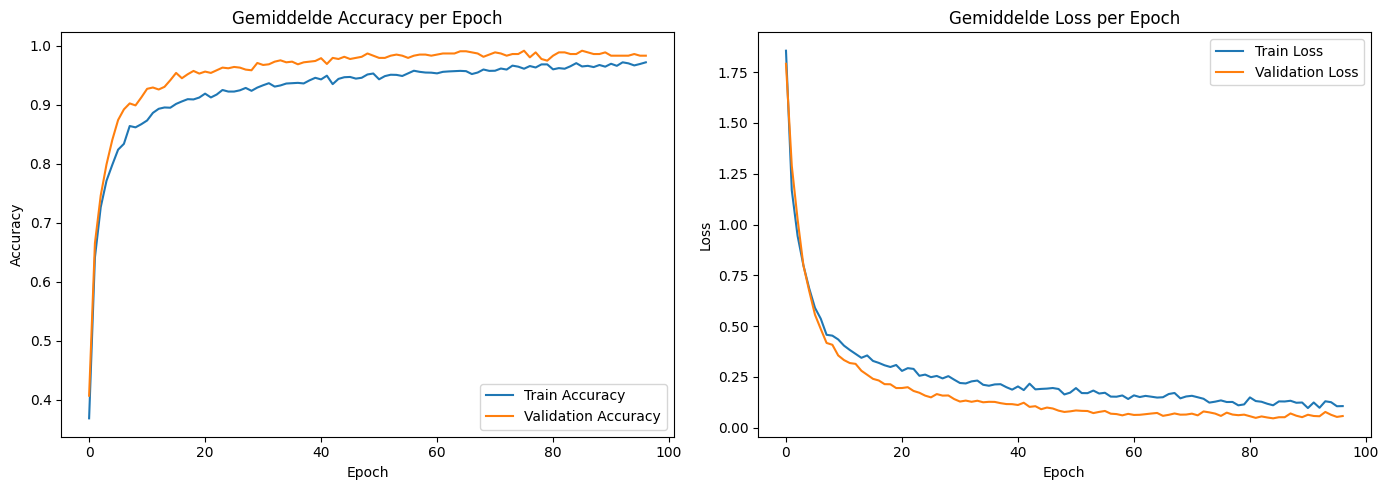

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_history(histories):
    max_epochs = max(len(h.history['accuracy']) for h in histories)

    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []

    for h in histories:
        num_epochs = len(h.history['accuracy'])

        # Vul aan tot max_epochs met NaN
        train_acc = np.array(h.history['accuracy'] + [np.nan] * (max_epochs - num_epochs))
        val_acc = np.array(h.history['val_accuracy'] + [np.nan] * (max_epochs - num_epochs))
        train_loss = np.array(h.history['loss'] + [np.nan] * (max_epochs - num_epochs))
        val_loss = np.array(h.history['val_loss'] + [np.nan] * (max_epochs - num_epochs))

        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)
        all_train_loss.append(train_loss)
        all_val_loss.append(val_loss)

    avg_train_acc = np.nanmean(all_train_acc, axis=0)
    avg_val_acc = np.nanmean(all_val_acc, axis=0)
    avg_train_loss = np.nanmean(all_train_loss, axis=0)
    avg_val_loss = np.nanmean(all_val_loss, axis=0)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(avg_train_acc, label='Train Accuracy')
    plt.plot(avg_val_acc, label='Validation Accuracy')
    plt.title("Gemiddelde Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(avg_train_loss, label='Train Loss')
    plt.plot(avg_val_loss, label='Validation Loss')
    plt.title("Gemiddelde Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_avg_history(histories)


# Extra laag toevoegen

In [19]:
def create_cnn_model(input_shape=(64, 64, 1), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
         layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Cross-validatie loop

In [20]:
os.makedirs("models", exist_ok=True)
os.makedirs("misclassificaties", exist_ok=True)

kf = KFold(n_splits=5, shuffle=True, random_state=2003)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

N = len(X)
histories = []
fold = 1

for train_index, val_index in kf.split(X):
    print(f"\nFold {fold}")

    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_cnn_model()

    train_generator = DualPathAugmentGenerator(
        X_train, y_train,
        batch_size=32,
        strong_aug=strong_albu,
        weak_aug=weak_albu,
        ruis_func=voeg_rafelruis_toe,
        shuffle=True
    )

    # Validatiebeelden éénmalig zwak aug + ruis
    X_val_aug = []
    for img in X_val:
        img = weak_albu(image=img.astype(np.float32))['image']
        img = voeg_rafelruis_toe(img)
        X_val_aug.append(img)
    X_val_aug = np.stack(X_val_aug)

    checkpoint_path = f"models/best_model_fold{fold}.keras"
    checkpoint_cb = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_accuracy',
        save_best_only=True
    )

    history = model.fit(
        train_generator,
        validation_data=(X_val_aug, y_val),
        epochs=200,
        callbacks=[early_stop, checkpoint_cb],
        verbose=1
    )
    histories.append(history)

    best_model = load_model(checkpoint_path)
    y_pred_probs = best_model.predict(X_val_aug)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f'Confusion Matrix - Fold {fold}')
    output_dir = Path(f"misclassificaties/fold{fold}")
    output_dir.mkdir(parents=True, exist_ok=True)
    plt.savefig(output_dir / "confusion_matrix.png")
    plt.close()

    print(f"Misclassificaties opslaan voor Fold {fold}")
    for i, (true, pred) in enumerate(zip(y_val, y_pred)):
        if true != pred:
            img = X_val_aug[i]
            if img.dtype != np.uint8:
                img = np.clip(img, 0, 1)
                img = (img * 255).astype(np.uint8)

            if img.ndim == 2:
                pil_img = Image.fromarray(img, mode="L")
            elif img.shape[2] == 1:
                pil_img = Image.fromarray(img.squeeze(), mode="L")
            else:
                pil_img = Image.fromarray(img)

            pil_img.save(output_dir / f"true_{true}_pred_{pred}_idx_{i}.png")

    fold += 1



Fold 1


c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.2224 - loss: 2.1180 - val_accuracy: 0.4831 - val_loss: 1.5921
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.6095 - loss: 1.2673 - val_accuracy: 0.7978 - val_loss: 0.9882
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.7245 - loss: 0.8748 - val_accuracy: 0.8090 - val_loss: 0.7107
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 298ms/step - accuracy: 0.8041 - loss: 0.6538 - val_accuracy: 0.9101 - val_loss: 0.4866
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 234ms/step - accuracy: 0.8238 - loss: 0.5407 - val_accuracy: 0.9045 - val_loss: 0.3995
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 228ms/step - accuracy: 0.8527 - loss: 0.4739 - val_accuracy: 0.8708 - val_loss: 0.4041
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 209ms/step - accuracy: 0.8508 - loss: 0.4877 - val_accuracy: 0.9382 - val_loss: 0.2732
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 5s 222ms/step - accuracy: 0.8875 - loss: 0.3705 - val_accu

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.2164 - loss: 2.1646 - val_accuracy: 0.4438 - val_loss: 1.6741
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - accuracy: 0.5871 - loss: 1.2590 - val_accuracy: 0.7303 - val_loss: 1.0489
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.7292 - loss: 0.8666 - val_accuracy: 0.8315 - val_loss: 0.6951
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 262ms/step - accuracy: 0.8229 - loss: 0.6051 - val_accuracy: 0.8933 - val_loss: 0.4560
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.8456 - loss: 0.4810 - val_accuracy: 0.8933 - val_loss: 0.3533
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.8682 - loss: 0.4116 - val_accuracy: 0.9101 - val_loss: 0.3173
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.8742 - loss: 0.3811 - val_accuracy: 0.9326 - val_loss: 0.2404
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 242ms/step - accuracy: 0.8892 - loss: 0.3685 - val_accu

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.2031 - loss: 2.1645 - val_accuracy: 0.4775 - val_loss: 1.6654
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.5415 - loss: 1.3336 - val_accuracy: 0.6910 - val_loss: 1.1220
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 271ms/step - accuracy: 0.7404 - loss: 0.8805 - val_accuracy: 0.7865 - val_loss: 0.7199
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.7862 - loss: 0.6850 - val_accuracy: 0.9101 - val_loss: 0.4679
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.8226 - loss: 0.6060 - val_accuracy: 0.9326 - val_loss: 0.3266
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 290ms/step - accuracy: 0.8452 - loss: 0.5270 - val_accuracy: 0.9213 - val_loss: 0.2760
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.8850 - loss: 0.3959 - val_accuracy: 0.9551 - val_loss: 0.2400
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.8883 - loss: 0.4146 - val_accu

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 271ms/step - accuracy: 0.1804 - loss: 2.1908 - val_accuracy: 0.4045 - val_loss: 1.6642
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 285ms/step - accuracy: 0.6025 - loss: 1.2158 - val_accuracy: 0.7753 - val_loss: 0.9856
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 237ms/step - accuracy: 0.7567 - loss: 0.8603 - val_accuracy: 0.8371 - val_loss: 0.6534
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - accuracy: 0.7955 - loss: 0.6231 - val_accuracy: 0.9157 - val_loss: 0.3737
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - accuracy: 0.8624 - loss: 0.4529 - val_accuracy: 0.9438 - val_loss: 0.3067
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.8714 - loss: 0.4110 - val_accuracy: 0.9382 - val_loss: 0.2471
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.8953 - loss: 0.3754 - val_accuracy: 0.9663 - val_loss: 0.2360
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 272ms/step - accuracy: 0.8853 - loss: 0.3833 - val_accu

c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 8s 283ms/step - accuracy: 0.1805 - loss: 2.1765 - val_accuracy: 0.3989 - val_loss: 1.7528
Epoch 2/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.5868 - loss: 1.2475 - val_accuracy: 0.8034 - val_loss: 0.8898
Epoch 3/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.7247 - loss: 0.8471 - val_accuracy: 0.8427 - val_loss: 0.6162
Epoch 4/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 270ms/step - accuracy: 0.8236 - loss: 0.5861 - val_accuracy: 0.8708 - val_loss: 0.4346
Epoch 5/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 313ms/step - accuracy: 0.8670 - loss: 0.4598 - val_accuracy: 0.8989 - val_loss: 0.3665
Epoch 6/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 255ms/step - accuracy: 0.8514 - loss: 0.4378 - val_accuracy: 0.8820 - val_loss: 0.4047
Epoch 7/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 287ms/step - accuracy: 0.8709 - loss: 0.4116 - val_accuracy: 0.9326 - val_loss: 0.3007
Epoch 8/200
23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - accuracy: 0.9044 - loss: 0.2978 - val_accu

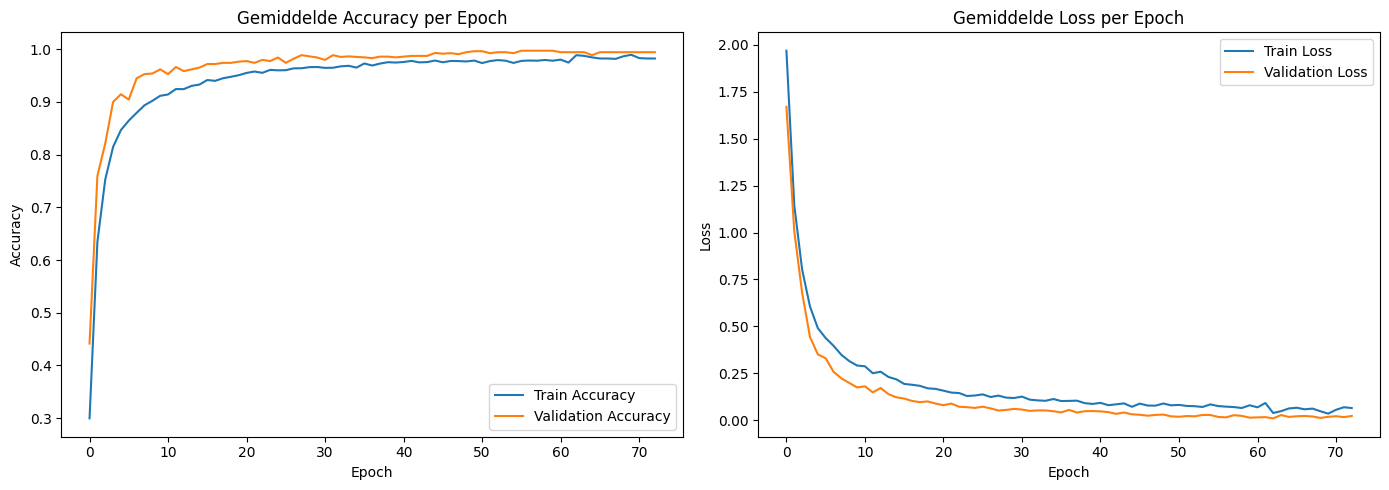

In [21]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_history(histories):
    max_epochs = max(len(h.history['accuracy']) for h in histories)

    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []

    for h in histories:
        num_epochs = len(h.history['accuracy'])

        # Vul aan tot max_epochs met NaN
        train_acc = np.array(h.history['accuracy'] + [np.nan] * (max_epochs - num_epochs))
        val_acc = np.array(h.history['val_accuracy'] + [np.nan] * (max_epochs - num_epochs))
        train_loss = np.array(h.history['loss'] + [np.nan] * (max_epochs - num_epochs))
        val_loss = np.array(h.history['val_loss'] + [np.nan] * (max_epochs - num_epochs))

        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)
        all_train_loss.append(train_loss)
        all_val_loss.append(val_loss)

    avg_train_acc = np.nanmean(all_train_acc, axis=0)
    avg_val_acc = np.nanmean(all_val_acc, axis=0)
    avg_train_loss = np.nanmean(all_train_loss, axis=0)
    avg_val_loss = np.nanmean(all_val_loss, axis=0)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(avg_train_acc, label='Train Accuracy')
    plt.plot(avg_val_acc, label='Validation Accuracy')
    plt.title("Gemiddelde Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(avg_train_loss, label='Train Loss')
    plt.plot(avg_val_loss, label='Validation Loss')
    plt.title("Gemiddelde Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_avg_history(histories)


# Trainen hele train set (geen K-fold)

In [23]:
def create_cnn_model(input_shape=(64, 64, 1), num_classes=10):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
         layers.Conv2D(128, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
# Opslagmap
os.makedirs("models", exist_ok=True)

# Augmentatiegenerator voor training
train_generator = DualPathAugmentGenerator(
    X=X,
    y=y,
    batch_size=32,
    strong_aug=strong_albu,
    weak_aug=weak_albu,
    ruis_func=voeg_rafelruis_toe,
    shuffle=True
)

# Model initialiseren
model = create_cnn_model()

# Model checkpoint – monitor training accuracy
checkpoint_cb = ModelCheckpoint(
    filepath="models/final_model_full_train.keras",
    monitor='accuracy',
    mode='max',
    save_best_only=True,
    save_weights_only=False
)

# Train het model
history = model.fit(
    train_generator,
    epochs=75,
    callbacks=[checkpoint_cb],
    verbose=1
)

# Laad het beste model na training
final_model = load_model("models/final_model_full_train.keras")


c:\Users\lenka\anaconda3\envs\TataSteel2\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 217ms/step - accuracy: 0.2399 - loss: 2.1265
Epoch 2/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 231ms/step - accuracy: 0.6254 - loss: 1.1454
Epoch 3/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 213ms/step - accuracy: 0.7696 - loss: 0.7652
Epoch 4/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 226ms/step - accuracy: 0.8256 - loss: 0.5335
Epoch 5/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.8547 - loss: 0.4409
Epoch 6/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 202ms/step - accuracy: 0.8999 - loss: 0.3279
Epoch 7/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 7s 246ms/step - accuracy: 0.8985 - loss: 0.3310
Epoch 8/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 10s 347ms/step - accuracy: 0.9215 - loss: 0.2577
Epoch 9/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 11s 397ms/step - accuracy: 0.9282 - loss: 0.2411
Epoch 10/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 337ms/step - accuracy: 0.9087 - loss: 0.2580
Epoch 11/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 9s 302ms/step - accuracy: 0.9240 - loss: 0.2467
Epoch 12/75
28/28 ━━━━━━━━━━━━━━━━━━━━ 12s 435ms/s

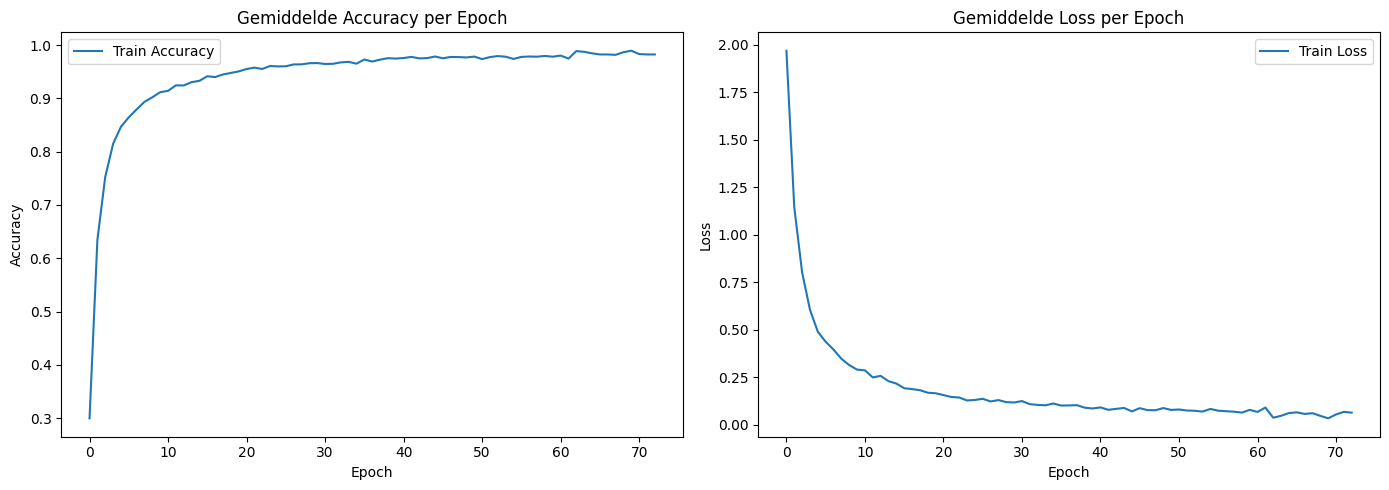

In [25]:
import numpy as np
import matplotlib.pyplot as plt

def plot_avg_history(histories):
    max_epochs = max(len(h.history['accuracy']) for h in histories)

    all_train_acc = []
    all_val_acc = []
    all_train_loss = []
    all_val_loss = []

    for h in histories:
        num_epochs = len(h.history['accuracy'])

        # Vul aan tot max_epochs met NaN
        train_acc = np.array(h.history['accuracy'] + [np.nan] * (max_epochs - num_epochs))
        val_acc = np.array(h.history['val_accuracy'] + [np.nan] * (max_epochs - num_epochs))
        train_loss = np.array(h.history['loss'] + [np.nan] * (max_epochs - num_epochs))
        val_loss = np.array(h.history['val_loss'] + [np.nan] * (max_epochs - num_epochs))

        all_train_acc.append(train_acc)
        all_val_acc.append(val_acc)
        all_train_loss.append(train_loss)
        all_val_loss.append(val_loss)

    avg_train_acc = np.nanmean(all_train_acc, axis=0)
    avg_val_acc = np.nanmean(all_val_acc, axis=0)
    avg_train_loss = np.nanmean(all_train_loss, axis=0)
    avg_val_loss = np.nanmean(all_val_loss, axis=0)

    plt.figure(figsize=(14, 5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(avg_train_acc, label='Train Accuracy')
    plt.title("Gemiddelde Accuracy per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(avg_train_loss, label='Train Loss')
    plt.title("Gemiddelde Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.tight_layout()
    plt.show()


plot_avg_history(histories)


# Visualiseren model architectuur

In [ ]:
import visualkeras

model = load_model("models/final_model_full_train.keras")


In [43]:
img = visualkeras.layered_view(
    model,
    legend=True,
    draw_volume=True,
    spacing=10,
    max_z=8,
    scale_xy=1,
    scale_z=1
)

# Vergroot het beeld voor betere scherpte
img = img.resize((img.width * 4, img.height * 4), Image.LANCZOS)
img.save("model_visual_highres.png")

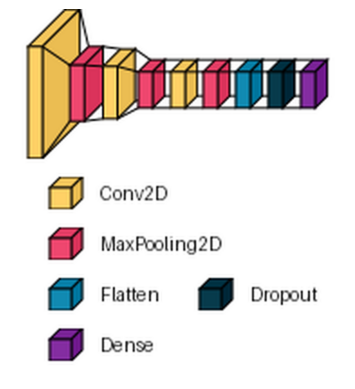

In [46]:
import matplotlib.pyplot as plt

img = plt.imread("model_visual_highres.png")

plt.imshow(img)
plt.axis('off')  # Verberg de assen


plt.show()